In [1]:
from disk_utils_jax import jax_model
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

from jaxopt import ScipyMinimize

jax.config.update("jax_enable_x64", True)

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [5]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.5, 'g2': 0.5, 'weight': 0.5})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:05.817229
0:00:00.000464


In [6]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

## Running Optimizations with more Parameters

In [7]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spf params, 0: g1, 1: g2, 2: weight
spf_params_jax = jnp.array([0.5, 0.5, 0.5])

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

### Checking if log-likelihood method works

In [10]:
from regression import log_likelihood_1d_pos_all_pars

# If nans are seen, Jax Opt won't work
llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

grad_func = jax.grad(llp, argnums=(0))

print(grad_func(all_pars))

jax.config.update("jax_debug_nans", False)

[-4260.31461957  7784.52078321 -5874.75333443  5725.34603858
   -45.77673435 43341.30357767 43341.30357767     0.        ]


In [11]:
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
soln_sm, ignore = solver.run(init_params=all_pars)

disk_fit_jaxopt = {'alpha_in': soln_sm[0], 'alpha_out': soln_sm[1], 'sma': soln_sm[2], 'inclination': soln_sm[3], 'position_angle': soln_sm[4]}


### Likelihood Results

In [12]:
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

JAX Optimization Disk Parameters: {'alpha_in': Array(5.72448918, dtype=float64), 'alpha_out': Array(-9.66770085, dtype=float64), 'sma': Array(39.85561709, dtype=float64), 'inclination': Array(37.75677696, dtype=float64), 'position_angle': Array(30.31412338, dtype=float64)}{'g1': Array(0.24923146, dtype=float64), 'g2': Array(0.24923146, dtype=float64), 'weight': Array(0.5, dtype=float64)}
Log-Likelihood: 86867.49552295591
Actual Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86414.04279412574


### Image Comparisions

In [13]:
disk_fit_jaxopt['flux_scaling'] = 1e6
spf_params_jaxopt = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])

print(disk_fit_jaxopt)
print(spf_params_jaxopt)

disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params=DoubleHenyeyGreenstein_SPF.unpack_pars(spf_params_jax))

disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params=spf_params_jaxopt)

{'alpha_in': Array(5.72448918, dtype=float64), 'alpha_out': Array(-9.66770085, dtype=float64), 'sma': Array(39.85561709, dtype=float64), 'inclination': Array(37.75677696, dtype=float64), 'position_angle': Array(30.31412338, dtype=float64), 'flux_scaling': 1000000.0}
{'g1': Array(0.24923146, dtype=float64), 'g2': Array(0.24923146, dtype=float64), 'weight': Array(0.5, dtype=float64)}


Text(0.5, 1.0, 'Target Model')

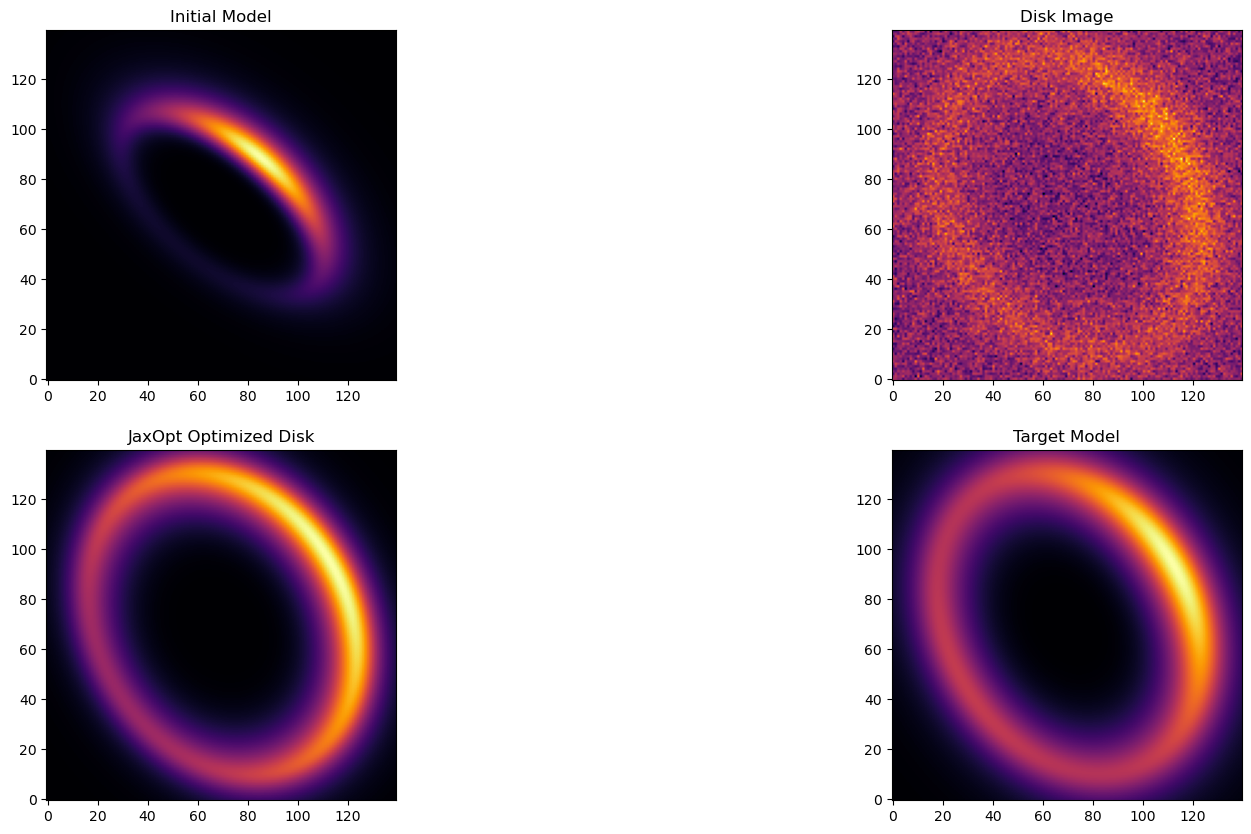

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[1][0].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][0].set_title("JaxOpt Optimized Disk")

axes[1][1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1][1].set_title("Target Model")

In [15]:
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
def jax_optimization_test():
    res = solver.run(init_params=all_pars)

#### Testing Runtimes

In [16]:

%timeit jax_optimization_test()

3.36 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
